## Training a Deep Q-Learning Agent for Connect-4

Notebook made by Clément Boulay. <br>
Inspired from lab 4.

## Summary
1. <a href="#Imports">Imports</a>
2. <a href="#SupportFunctions">Support functions</a>
3. <a href="#DummyAgent">DummyAgent class</a>
4. <a href="#MLP">Multi-Layer Perceptron base class</a>
5. <a href="#ReplayBuffer">ReplayBuffer for DQN convergence</a>
6. <a href="#DQN">Main Deep Q-Networks class</a>
7. <a href="#TrainEvaluationLoops">Training and Evaluation loops</a>
8. <a href="#TwoDummyAgents">Testing 2 DummyAgent against each other</a>
9. <a href="#Experiments">Experiments with the DQN Agent</a>
   1. <a href="#Exp1">Experiment 1</a>
   2. <a href="#Exp2">Experiment 2</a>
   3. <a href="#Exp3">Experiment 3</a>
   4. <a href="#Exp4">Experiment 4</a>

## Imports 
<div id="Imports"></div>

In [12]:
# native imports
from copy import deepcopy
import os
import random
import sys

In [13]:
# other imports
import gymnasium as gym
from gymnasium.spaces import Space # for typing
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pettingzoo
from pettingzoo.classic import connect_four_v3
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
%matplotlib inline
matplotlib.style.use('ggplot')

In [15]:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"PettingZoo version: {pettingzoo.__version__}")

Python version: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 1.11.0+cpu
Numpy version: 1.23.5
Gymnasium version: 0.27.1
PettingZoo version: 1.22.4


## Support functions
<div id="SupportFunctions"></div>

In [16]:
def is_legal(observation, action):
    """ 
    Return True if action is legal (ie., the corresponding column isn't full), else return False.

    - observation (numpy.ndarray): a (6, 7, 2) array with columns on the second axis.
    - action (int): ID of proposed action
    """
    # get state of all columns
    obs = observation['observation']
    # print(obs)
    cols = np.sum(np.sum(obs, axis=2), axis=0)
    # print(cols)
    # conclude accordingly
    if cols[action] >= 6:
        return False
    else:
        return True

## A DummyAgent to play against
<div id="DummyAgent"></div>

In [17]:
class DummyAgent:
    """ 
    Implement a DummyAgent that plays at random to train our DQN Agent against.
    """ 
    def __init__(self, env, player_name: str):
        self.env = deepcopy(env)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.name = player_name
        self.unique_id = int(self.name[-1])
    
    def get_action(self, state, *args):
        """  
        The Agent plays at random.
        """
        action = self.action_space(self.env.agents[self.unique_id]).sample()
        while not is_legal(state, action):
            action = self.action_space(self.env.agents[self.unique_id]).sample()
        return action
    
    def update(self, *data):
        """ 
        There is no update here.
        """
        pass

## Simple Multi-Layer Perceptron class
<div id="MLP"></div>

In [18]:
class MLP(nn.Module):
    """
    Basic Multi-Layer Perceptron.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
        # important note: there is no softmax here!

    def forward(self, x):
        # print(f"Size of input is the MLP class: {x.size()}")
        return self.net(x)

## Implementing the replay buffer
<div id="ReplayBuffer"></div>

In [19]:
class ReplayBuffer:
    """
    Implement a ReplayBuffer class that we will use for stacking data for backpropagation.
    """
    def __init__(self, capacity: int):
        self.capacity = capacity
        print(f"[ReplayBuffer] Initializing a ReplayBuffer with capacity: {self.capacity}")
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """
        Saves a transition into the buffer iff there is capacity left.
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q-Networks main class
<div id="DQN"></div>

In [20]:
class DQN:
    """  
    Implement a Deep Q-Network environment.
    """
    def __init__(self,
                env,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                player_name: str = "player_0"
                ): 
        self.env = deepcopy(env)
        self.name = player_name
        self.unique_id = int(self.name[-1])
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        self.epsilon_start = epsilon_start
        # larger epsilon factor means more exploration
        self.decrease_epsilon_factor = decrease_epsilon_factor
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        print(f"[DQN] Initializing a DQN agent as: {self.name}")
        self.reset()
        
    def get_action(self, state, epsilon=None):
        """
            Return an action according to an epsilon-greedy exploration policy.
        """
        if epsilon is None: 
            epsilon = self.epsilon
        
        action = None
        q_action = np.argmax(self.get_q(state))
        # case 1: the Q-Action is not legal; we must play at random
        if not is_legal(state, q_action):
            while (action is None) or (not is_legal(state, action)):
                action = self.env.action_space(self.name).sample()
        else:
            while (action is None) or (not is_legal(state, action)):
                if np.random.rand() < epsilon: 
                    action = self.env.action_space(self.name).sample()
                else: 
                    return np.argmax(self.get_q(state))
        return action       
    
    def update(self, state, action, reward, terminated, next_state):
        """
        Update the target
        """
        # add data to replay buffer
        if state is None or next_state is None:
            return -1
        
        # print(f"State: {state}\nAction: {action}\nReward: {reward}\nTerminated: {terminated}\nNext state: {next_state}\n")
        self.buffer.push(torch.tensor(state['observation']).unsqueeze(0), 
                            torch.tensor([[action]], dtype=torch.int64), 
                            torch.tensor([reward]), 
                            torch.tensor([terminated], dtype=torch.int64), 
                            torch.tensor(next_state['observation']).unsqueeze(0),
                            )

        # print(f"[DQN] Buffer size: {len(self.buffer)}")
        # if len(self.buffer) < self.batch_size:
        #     return -1
    
        # if we have gathered enough data, get a batch
        transitions = self.buffer.sample(self.batch_size)

        # Compute loss
        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        flatten_tensor = torch.flatten(state_batch, start_dim=1, end_dim=3).float()
        # print(f"Flatten tensor shape in agent update: {flatten_tensor.size()}")
        values = self.q_net.forward(flatten_tensor).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            flatten_tensor_target_net = torch.flatten(next_state_batch, start_dim=1, end_dim=3).float()
            next_state_values = (1 - terminated_batch) * self.target_net(flatten_tensor_target_net).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state['observation']).unsqueeze(0)
        flatten_tensor = torch.flatten(state_tensor, start_dim=1, end_dim=3).float()
        with torch.no_grad():
            # print("Flattened tensor: ", flatten_tensor)
            output = self.q_net.forward(flatten_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):
        """ 
        Plays a role identical to __init__, but with fixed attributes.
        """
        # hidden layer size for the Q-Network
        self.hidden_size = 128
        # the observation size is fixed for Connect-4
        self.num_rows = 6
        self.num_cols = 7
        num_players = 2
        self.obs_size = self.num_cols*self.num_rows*num_players
        # as well as the number of possible actions - some might be become illegal during the game
        self.n_actions = self.num_cols
        
        self.buffer = ReplayBuffer(self.buffer_capacity)
        # this is the behavioral network which aims at learning the optimal Action-State values
        self.q_net =  MLP(self.obs_size, self.hidden_size, self.n_actions)
        # this is the estimation network, which will be update frequently
        self.target_net = MLP(self.obs_size, self.hidden_size, self.n_actions)
        
        # we will use a Mean Squared Error loss function
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)
        
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

## Training and evaluation loops
<div id="TrainEvaluationLoops"></div>

In [21]:
def run_one_episode(env, agent_id: int, player_0, player_1, display=False):
    """ 
    Run a single game of Connect-4.
    """
    agents = [player_0, player_1]
    done = False
    state = env.reset()
    # rewards will only be computed for the player whose ID matches agent_id
    rewards = 0

    while not done:
        for agent in agents:
            state, reward, termination, truncation, info = env.last()
            done = termination or truncation
            # print(f"Turn of agent {agent.unique_id}")
            # print("Reward:", reward)
            if agent.unique_id == agent_id:
                rewards += reward
            if done: 
                break
            else:
                action = agent.get_action(state)
                env.step(action)
            
            if display: 
                env.render()

    if display:
        env.close()
    return rewards

In [34]:
def train(env, agent_id, player_0, player_1, N_episodes, eval_every=50, reward_threshold=0.9):
    """ 
    Train a DQN agent against a DummyAgent which plays at random.
    """
    print("[Train] Training the DQN Agent using a Dummy Agent as opponent.")
    agents = [player_0, player_1]
    losses = []
    all_rewards = []
    
    for ep in range(N_episodes):
        print(f"[Train] Episode {ep+1}/{N_episodes}")
        done = False
        state = env.reset()
        ep_length = 0
        while not done:
            ep_length += 1
            # print(f"Ep length is: {ep_length}")
            for agent in agents:
                next_state, reward, terminated, truncated, info = env.last()
                done = terminated or truncated
                if done:
                    break 
                else:
                    action = agent.get_action(next_state)
                    env.step(action)
                    if agent.unique_id == agent_id:
                        loss_val = agent.update(state, action, reward, terminated, next_state)
                        losses.append(loss_val)
                        state = next_state                
                    
        if ep%eval_every == 0:
            print("[Train] Evaluating the DQN Agent.")
            rewards = eval_agent(env, agent_id, player_0, player_1, n_sim=20)
            all_rewards.append(np.mean(rewards))
            print(f"Mean reward is: {np.mean(rewards)}")
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses, all_rewards

In [23]:
def eval_agent(env, agent_id: int, player_0, player_1, n_sim: int = 5):
    """
    Monte Carlo evaluation of DQN agent.

    Inputs:
        - agent_id: the ID (either 0 or 1) of the DQN Agent.
        - player_0: a DQN instance or a DummyAgent instance depending on which plays first
        - n_sim : number of episodes to run for evaluating the DQN Agent

    The process is as follows:
        - for a fixed policy followed by the DQN Agent, run n_sim full episodes
        - for each full episode ran, compute the sum of rewards in this episode
        - and store it into the episode_rewards array that will be returned
    """
    agents = [player_0, player_1]
    # rewards will only be computed for the player whose ID matches the agent_id
    episodes_rewards = np.zeros(n_sim)

    for ep in range(n_sim):
        state = env.reset()
        reward_sum = 0
        done = False
        while not done: 
            for agent in agents:
                state, reward, terminated, truncated, info = env.last()
                if agent.unique_id == agent_id:
                    reward_sum += reward
                done = terminated or truncated
                if done:
                    break
                else:
                    # we have the guarantee by the get_action method that the action is legal
                    action = agent.get_action(state)
                    env.step(action)
                
        episodes_rewards[ep] = reward_sum
    return episodes_rewards

## Testing two DummyAgents against each other
<div id="TwoDummyAgents"></div>

In [24]:
env = connect_four_v3.env('human')
env.reset()
player_0 = DummyAgent(env, player_name="player_0")
player_1 = DummyAgent(env, player_name="player_1")

In [25]:
for i in range(10):
    env.reset()
    cumulated_reward = run_one_episode(env, agent_id=0, player_0=player_0, player_1=player_1, display=False)
    print(f"Reward for episode {i} is: {cumulated_reward}")

Reward for episode 0 is: 1
Reward for episode 1 is: 0
Reward for episode 2 is: 1
Reward for episode 3 is: 0
Reward for episode 4 is: 1
Reward for episode 5 is: 0
Reward for episode 6 is: 0
Reward for episode 7 is: 0
Reward for episode 8 is: 1
Reward for episode 9 is: 1


In [27]:
n_sim = 30
all_rewards = eval_agent(
      env,
      agent_id=0,
      player_0=player_0,
      player_1=player_1,
      n_sim=n_sim)
print(f'Average over {n_sim} runs : {round(np.mean(all_rewards), 2)}')

Average over 30 runs : 0.47


## Experiments with the DQN Agent
<div id="Experiments"></div>

The target will be to outperform 0.6 while evaluating (result from the previous section when playing first).

In [28]:
env = connect_four_v3.env('human')
env.reset()

In [75]:
# just in case you need to rerun the simulation
# env.close()

In [29]:
# static hyperparameters
N_episodes = 1000
buffer_capacity = 100
epsilon_start = 0.9
epsilon_end = 0.05
gamma = 0.9 # discount factor

In [30]:
# EXPERIMENT 1
learning_rate = 1e-1
batch_size = 8
decrease_epsilon_factor = 1000
f_target = [8, 16, 32, 64]
arguments_exp1 = []

for update_target_every in f_target:
    arguments_exp1.append((
            env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_end,
            learning_rate,
            "player_0"
        ))

In [31]:
# EXPERIMENT 2
learning_rates = [0.1, 0.05, 0.01, 0.001]
batch_size = 8
decrease_epsilon_factor = 1000
update_target_every = 16 # f_target
arguments_exp2 = []

for learning_rate in learning_rates:
    arguments_exp2.append((
            env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_end,
            learning_rate,
            "player_0"
        ))

In [32]:
# EXPERIMENT 3
batch_sizes = [8, 16, 32, 64]
update_target_every = 16 # f_target
learning_rate = 0.1
decrease_epsilon_factor = 1000
arguments_exp3 = []

for batch_size in batch_sizes:
    arguments_exp3.append((
            env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_end,
            learning_rate,
            "player_0"
        ))

In [33]:
# EXPERIMENT 4
batch_size = 8
update_target_every = 16 # f_target
learning_rate = 0.1
decrease_epsilon_factors = [10, 50, 100, 1000]
arguments_exp4 = []

for decrease_epsilon_factor in decrease_epsilon_factors:
    arguments_exp4.append((
            env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_end,
            learning_rate,
            "player_0"
        ))

### Experiment 1
<div id="Exp1"></div>

In [77]:
results_exp1 = []
player_1 = DummyAgent(env, player_name="player_1")
for argument_exp1 in arguments_exp1:
    player_0 = DQN(*argument_exp1)
    train_losses, all_rewards = train(env,
                            agent_id=0,
                            player_0=player_0,
                            player_1=player_1,
                            N_episodes=N_episodes,
                            eval_every=50)
    rewards = eval_agent(env, 0, player_0, player_1, 100)
    # score is the mean of the last 10 evaluations
    results_exp1.append(np.mean(rewards[-10:]))

[DQN] Initializing a DQN agent as: player_0
[ReplayBuffer] Initializing a ReplayBuffer with capacity: 10000


### Experiment 2
<div id="Exp2"></div>

In [ ]:
results_exp2 = []
player_1 = DummyAgent(env, player_name="player_1")
for argument_exp2 in arguments_exp2:
    player_0 = DQN(*argument_exp2)
    train_losses, all_rewards = train(env,
                            agent_id=0,
                            player_0=player_0,
                            player_1=player_1,
                            N_episodes=N_episodes,
                            eval_every=50)
    rewards = eval_agent(env, 0, player_0, player_1, 100)
    # score is the mean of the last 10 evaluations
    results_exp2.append(np.mean(rewards[-10:]))

### Experiment 3
<div id="Exp3"></div>

In [ ]:
results_exp3 = []
player_1 = DummyAgent(env, player_name="player_1")
for argument_exp3 in arguments_exp3:
    player_0 = DQN(*argument_exp1)
    train_losses, all_rewards = train(env,
                            agent_id=0,
                            player_0=player_0,
                            player_1=player_1,
                            N_episodes=N_episodes,
                            eval_every=50)
    rewards = eval_agent(env, 0, player_0, player_1, 100)
    # score is the mean of the last 10 evaluations
    results_exp3.append(np.mean(rewards[-10:]))

### Experiment 4
<div id="Exp4"></div>

In [ ]:
results_exp4 = []
player_1 = DummyAgent(env, player_name="player_1")
for argument_exp4 in arguments_exp4:
    player_0 = DQN(*argument_exp1)
    train_losses, all_rewards = train(env,
                            agent_id=0,
                            player_0=player_0,
                            player_1=player_1,
                            N_episodes=N_episodes,
                            eval_every=50)
    rewards = eval_agent(env, 0, player_0, player_1, 100)
    # score is the mean of the last 10 evaluations
    results_exp4.append(np.mean(rewards[-10:]))

### Annexe : visualisation de l'apprentissage 
Vous pouvez faire tourner les codes suivants pour suivre l'apprentissage.

In [80]:
losses_formated = []
for loss in train_losses:
    if loss > 0:
        losses_formated.append(loss.item())

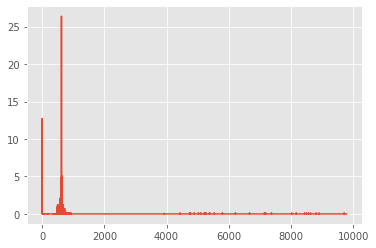

In [81]:
plt.plot(range(len(losses_formated)) + np.ones(shape=(len(losses_formated))), losses_formated)

(0.0, 1.0)

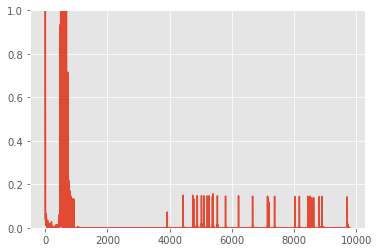

In [82]:
plt.plot(range(len(losses_formated)) + np.ones(shape=(len(losses_formated))), losses_formated)
plt.ylim(0, 1)

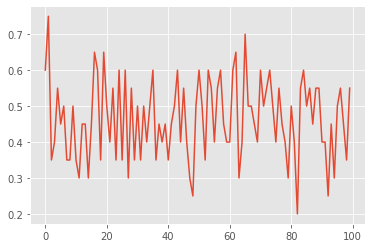

In [83]:
# plot rewards over evaluation episodes
plt.plot(range(len(all_rewards)), all_rewards)